In [0]:
import os, os.path, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
%matplotlib inline

In [9]:
!curl -L https://goo.gl/s8qSL5 -o ./bike_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  643k  100  643k    0     0   668k      0 --:--:-- --:--:-- --:--:-- 3318k


In [11]:
train = pd.read_csv("bike_train.csv",parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


연, 월, 일, 시 별 통계량

In [14]:
train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day","d-hour","d-minute","d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


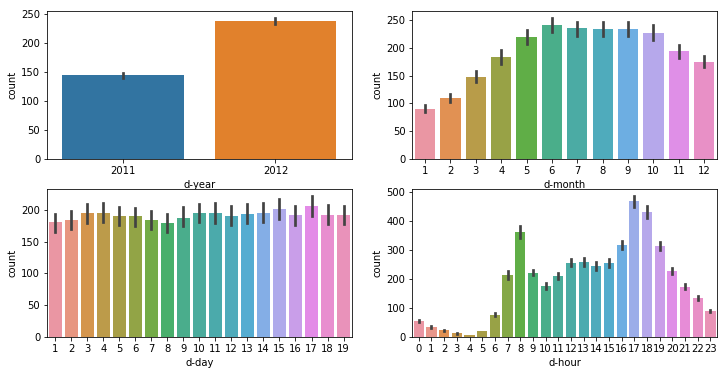

In [15]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(12,6)

sns.barplot(data = train, x = "d-year", y= "count", ax=ax1)
sns.barplot(data = train, x = "d-month", y= "count",ax=ax2)
sns.barplot(data = train, x = "d-day", y= "count",ax=ax3)
sns.barplot(data = train, x = "d-hour", y= "count",ax=ax4)

주중(workingday==1)<br>
주말(workingday==0)

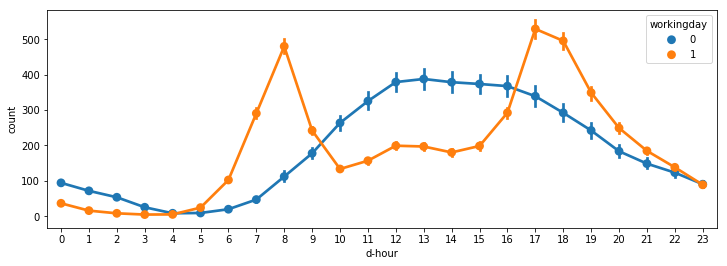

In [17]:
plt.figure(figsize = (12,4))
sns.pointplot(data=train,x="d-hour", y="count", hue="workingday")

요일별

In [20]:
train["d-dayofweek"] = train["datetime"].dt.dayofweek
print(train.shape)
train[["datetime","d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


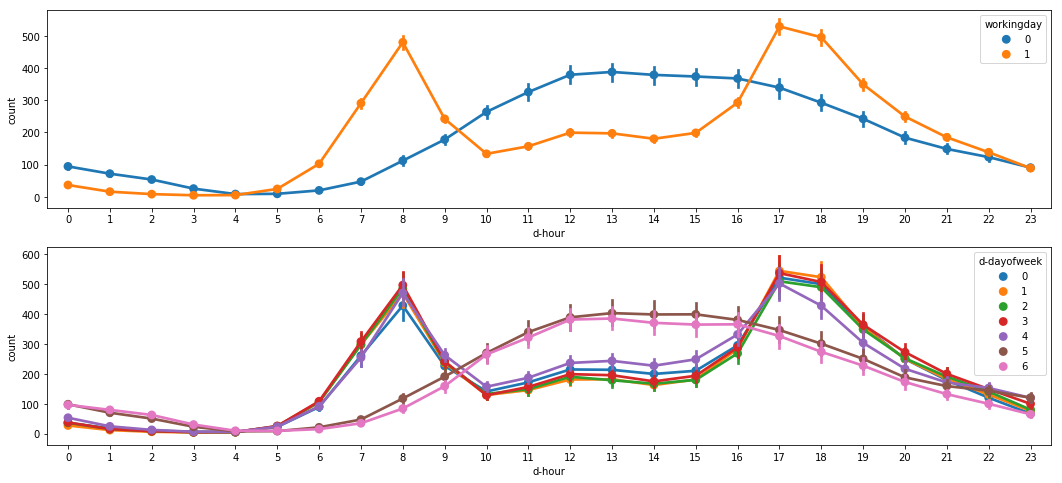

In [21]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18,8)

sns.pointplot(data = train, x="d-hour", y="count",hue="workingday", ax=ax1)
sns.pointplot(data = train, x="d-hour", y="count",hue="d-dayofweek", ax=ax2)

In [0]:
features = ["season", "holiday", "workingday", "weather","temp", "atemp","humidity","windspeed","d-year","d-hour","d-dayofweek"]

X_train = train[features]

In [0]:
y_train = train["count"]
y_train = np.log(y_train + 1)

In [38]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = predict + 1
    log_actual = actual + 1
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()    
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# 그리드 탐색

In [39]:
n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = []

for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=5,
                                scoring=rmsle_scorer).mean()

        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

Score = 0.57587
Score = 0.50518
Score = 0.47604
Score = 0.53160
Score = 0.47174
Score = 0.45804
Score = 0.53069
Score = 0.47177
Score = 0.46131


[{'max_depth': 10,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.5758738470123856},
 {'max_depth': 10,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.5051770417946189},
 {'max_depth': 10,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.4760424969352227},
 {'max_depth': 20,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.5316049223606947},
 {'max_depth': 20,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.47174478795305524},
 {'max_depth': 20,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.4580392231985776},
 {'max_depth': 30,
  'max_features': 0.3,
  'n_estimators': 30,
  'score': 0.5306895714523308},
 {'max_depth': 30,
  'max_features': 0.5,
  'n_estimators': 30,
  'score': 0.47177459094009927},
 {'max_depth': 30,
  'max_features': 0.9,
  'n_estimators': 30,
  'score': 0.46131356291799863}]

In [40]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

(9, 4)


,max_depth,max_features,n_estimators,score
5,20,0.9,30,0.458039
8,30,0.9,30,0.461314
4,20,0.5,30,0.471745
7,30,0.5,30,0.471775
2,10,0.9,30,0.476042
